# TP1 - Regresión
Notebook inicial para el trabajo práctico.

In [580]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import holidays

In [581]:
# 2. Carga de datos. Se carga el dataset que contiene los viajes de taxi.
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)

# visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [582]:
# Se realiza un análisis inicial para comprender el comportamiento de cada variable.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [583]:
df.apply(pd.unique)

key                  [24238194, 27835199, 44984355, 25894730, 17610...
date                 [2015-05-07 19:52:06.0000003, 2009-07-17 20:04...
fare_amount          [7.5, 7.7, 12.9, 5.3, 16.0, 4.9, 24.5, 2.5, 9....
pickup_datetime      [2015-05-07 19:52:06 UTC, 2009-07-17 20:04:56 ...
pickup_longitude     [-73.99981689453125, -73.994355, -74.005043, -...
pickup_latitude      [40.73835372924805, 40.728225, 40.74077, 40.79...
dropoff_longitude    [-73.99951171875, -73.99471, -73.962565, -73.9...
dropoff_latitude     [40.72321701049805, 40.750325, 40.772647, 40.8...
passenger_count                             [1, 3, 5, 2, 4, 6, 0, 208]
dtype: object

In [584]:
df.nunique()

key                  200000
date                 200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [585]:
# Eliminar la columna 'key' porque no aporta al análisis
df = df.drop(columns=['key'])

In [586]:
df['pickup_datetime'].isna().sum()

np.int64(0)

In [587]:
# Eliminar la columna 'date' porque redunda con el dato de 'pickup_datetime'
df = df.drop(columns=['date'])

In [588]:
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [589]:
# Verificar si hay valores NaN en fare__amount
df['fare_amount'].isna().sum()

np.int64(0)

Para lograr determinar si un fare amount grande es un outlier necesitamos calcular la variable distancia para lograr comprender si se corresponden los valores o no. Luego de una evaluación de la mejor función de distancia, llegamos a la conclusión que la manhattan se ajusta mejor a la estructura de la ciudad en estudio.

In [590]:
# Distancia Manhattan
def distancia_absoluta(lat1, lon1, lat2, lon2):
    """
    Calcula la suma de las diferencias absolutas entre latitud y longitud.
    Es decir, la distancia Manhattan en coordenadas.
    """
    return np.abs(lat2 - lat1) + np.abs(lon2 - lon1)

# Creamos al columna distancia
df["distancia_recorrida"] = distancia_absoluta(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

# Distancia Manhattan en kilómetros (aproximado)
df["distancia_recorrida_km"] = df["distancia_recorrida"] * 111

# Haversine
# Distancia haversine (en km)
def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_haversine'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

In [591]:
df['fare_amount'].value_counts().sort_index().tail(20)

fare_amount
163.00    1
165.00    1
165.33    1
170.00    1
171.35    1
180.00    1
183.00    1
190.00    1
190.83    1
191.80    1
192.33    1
196.00    1
200.00    1
206.38    1
220.00    1
230.00    1
250.00    1
275.00    1
350.00    1
499.00    1
Name: count, dtype: int64

In [592]:
df.nlargest(20, 'fare_amount')[['fare_amount', 'distancia_recorrida', 'distancia_recorrida_km', 'dist_haversine']]

,fare_amount,distancia_recorrida,distancia_recorrida_km,dist_haversine
170081,499.00,0.000011,0.001221,0.000790
4292,350.00,0.000000,0.000000,0.000000
185325,275.00,0.000000,0.000000,0.000000
71715,250.00,0.000000,0.000000,0.000000
197493,230.00,0.501812,55.701132,37.989067
29261,220.00,0.035656,3.957816,2.914493
23682,206.38,0.858774,95.323914,60.100889
196647,200.00,0.000000,0.000000,0.000000
184901,196.00,0.000017,0.001887,0.001259
33911,192.33,0.000000,0.000000,0.000000


In [593]:
df.sort_values('fare_amount', ascending=False)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine
170081,499.00,2011-04-10 04:10:00 UTC,-73.968377,40.764602,-73.968368,40.764600,1,0.000011,0.001221,0.000790
4292,350.00,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.000000,3,0.000000,0.000000,0.000000
185325,275.00,2013-04-19 00:00:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000
71715,250.00,2013-05-11 00:31:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000
197493,230.00,2014-09-07 08:39:00 UTC,-73.937765,40.758267,-74.382200,40.700890,2,0.501812,55.701132,37.989067
...,...,...,...,...,...,...,...,...,...,...
92063,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3,0.115183,12.785313,8.171296
89322,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5,0.000252,0.027972,0.019203
164056,-50.50,2010-03-16 15:27:10 UTC,-73.784868,40.648677,-73.976975,40.763522,3,0.306952,34.071672,20.622782
111589,-52.00,2015-02-23 19:26:44 UTC,-73.984665,40.759026,0.000000,0.000000,5,114.743690,12736.549644,8666.246939


In [594]:
# Resetear los índices del DataFrame después de los filtrados
df = df.reset_index(drop=True)
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450
...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,0.001447,0.160617,0.112210
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,0.024733,2.745363,1.875050
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,0.190959,21.196449,12.850319
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,0.043945,4.877930,3.539715


In [595]:
# Crear objeto de feriados de New York
feriados = holidays.US(state='NY')

# Si pickup_datetime es string, primero conviértelo a datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Crear la variable dummy: 1 si es feriado, 0 si no
df['es_feriado'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)

# Crear variable dummy: 1 si es fin de semana (sábado o domingo), 0 si es día de semana (lunes a viernes)
df['es_fin_de_semana'] = df['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Crear variable: 1 si es fin de semana o feriado, 0 si es día de semana y no feriado
df['es_no_laborable'] = ((df['es_fin_de_semana'] == 1) | (df['es_feriado'] == 1)).astype(int)

# Dropear columnas auxiliares
df = df.drop(columns=['es_feriado', 'es_fin_de_semana'])

df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.001447,0.160617,0.112210,1
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,0.024733,2.745363,1.875050,0
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0.190959,21.196449,12.850319,0
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,0.043945,4.877930,3.539715,0


In [596]:
# Crear variable 'hora_del_dia' (0 a 23) a partir de pickup_datetime
df['hora_del_dia'] = df['pickup_datetime'].dt.hour
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0,19
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0,21
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0,17


In [597]:
# Crear variables dummies según el día del mes de pickup_datetime
df['1era_mitad_mes'] = (df['pickup_datetime'].dt.day < 15).astype(int)
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0,19,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0,20,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0,21,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0,8,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.001447,0.160617,0.112210,1,10,0
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,0.024733,2.745363,1.875050,0,1,1
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0.190959,21.196449,12.850319,0,0,0
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,0.043945,4.877930,3.539715,0,14,0


In [598]:
# Crear variables senoidales a partir de hora_del_dia
df['hora_sin'] = np.sin(2 * np.pi * df['hora_del_dia'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_del_dia'] / 24)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,hora_sin,hora_cos
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0,19,1,-0.965926,0.258819
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0,20,0,-0.866025,0.500000
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0,21,0,-0.707107,0.707107
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0,8,0,0.866025,-0.500000
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0,17,0,-0.965926,-0.258819


In [599]:
df['pickup_datetime'] = df['pickup_datetime'].dt.tz_localize(None)

# Crear columna auxiliar 'estacion' según fechas astronómicas (hemisferio norte)
def estacion_astronomica(fecha):
    y = fecha.year
    if fecha >= pd.Timestamp(y, 12, 21) or fecha < pd.Timestamp(y, 3, 20):
        return 'invierno'
    elif fecha >= pd.Timestamp(y, 3, 20) and fecha < pd.Timestamp(y, 6, 21):
        return 'primavera'
    elif fecha >= pd.Timestamp(y, 6, 21) and fecha < pd.Timestamp(y, 9, 22):
        return 'verano'
    else:
        return 'otoño'

df['estacion'] = df['pickup_datetime'].apply(estacion_astronomica)

# Crear variables dummies de estación solo para invierno, primavera y verano
dummies = pd.get_dummies(df['estacion'], prefix='', prefix_sep='')
for estacion in ['invierno', 'primavera', 'verano']:
    df[estacion] = dummies.get(estacion, pd.Series(0, index=df.index)).astype(int)
# Otoño queda implícito: si las otras 3 son 0, es otoño
df = df.drop(columns=['estacion'])

# Visualiza las primeras filas
df[['pickup_datetime', 'invierno', 'primavera', 'verano']].head()

,pickup_datetime,invierno,primavera,verano
0,2015-05-07 19:52:06,0,1,0
1,2009-07-17 20:04:56,0,0,1
2,2009-08-24 21:45:00,0,0,1
3,2009-06-26 08:22:21,0,0,1
4,2014-08-28 17:47:00,0,0,1


In [600]:
# Crear variables dummies para passenger_count
df['delivery'] = (df['passenger_count'] == 0).astype(int)
df['standard'] = df['passenger_count'].between(1, 4).astype(int)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0,19,1,-0.965926,0.258819,0,1,0,0,1
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0,20,0,-0.866025,0.500000,0,0,1,0,1
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0,21,0,-0.707107,0.707107,0,0,1,0,1
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0,8,0,0.866025,-0.500000,0,0,1,0,1
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0,17,0,-0.965926,-0.258819,0,0,1,0,0


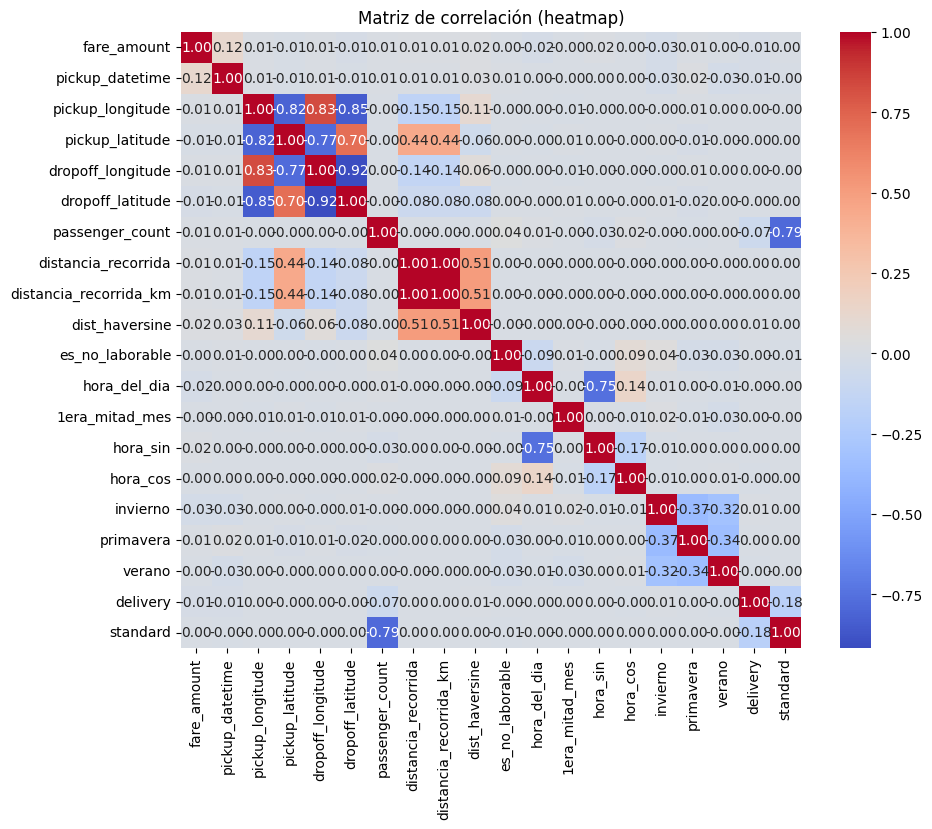

In [601]:
# Calcular la matriz de correlación antes de graficar
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap)')
plt.show()

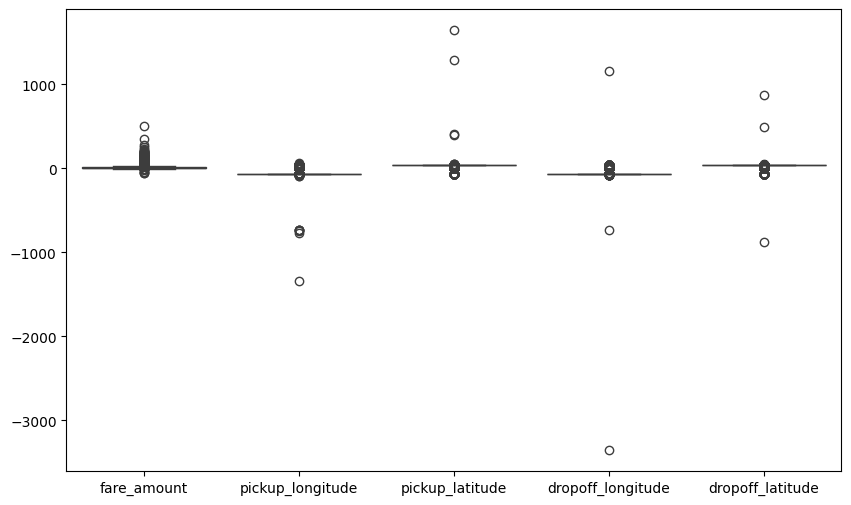

In [602]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
plt.show()

In [603]:
# División en train y test (80% - 20%)
y = df["fare_amount"]
X = df.drop(columns=["fare_amount"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [604]:
# Valores fuera de rango en longitudes
longitudes_fuera_rango = df_train[
    (df_train['pickup_longitude'] < -180) | (df_train['pickup_longitude'] > 180) |
    (df_train['dropoff_longitude'] < -180) | (df_train['dropoff_longitude'] > 180)
]

# Valores fuera de rango en latitudes
latitudes_fuera_rango = df_train[
    (df_train['pickup_latitude'] < -90) | (df_train['pickup_latitude'] > 90) |
    (df_train['dropoff_latitude'] < -90) | (df_train['dropoff_latitude'] > 90)
]

print("Longitudes fuera de rango:")
print(longitudes_fuera_rango[['pickup_longitude', 'dropoff_longitude']])

print("\nLatitudes fuera de rango:")
print(latitudes_fuera_rango[['pickup_latitude', 'dropoff_latitude']])

Longitudes fuera de rango:
        pickup_longitude  dropoff_longitude
103745       -736.216667         -73.982377
91422          57.418457        1153.572603
199936       -736.400000         -73.982215
4949         -748.016667         -74.003570
161652       -735.433332         -74.006373
75851       -1340.648410       -3356.666300
48506        -735.200000         -73.980187

Latitudes fuera de rango:
       pickup_latitude  dropoff_latitude
61793       401.066667         40.754117
91422      1292.016128       -881.985513
56617       404.433332         40.769037
75851      1644.421482        872.697628


In [605]:
# Son errores de carga o registro, no representan ubicaciones reales y son ínfimos, por lo que se procede a eliminarlos
df_train = df_train[
    (df_train['pickup_longitude'] >= -180) & (df_train['pickup_longitude'] <= 180) &
    (df_train['dropoff_longitude'] >= -180) & (df_train['dropoff_longitude'] <= 180) &
    (df_train['pickup_latitude'] >= -90) & (df_train['pickup_latitude'] <= 90) &
    (df_train['dropoff_latitude'] >= -90) & (df_train['dropoff_latitude'] <= 90)
]

In [606]:
# Ver y contar registros donde pickup_longitude y pickup_latitude son iguales a dropoff_longitude y dropoff_latitude
mask = (df['pickup_longitude'] == df['dropoff_longitude']) & (df['pickup_latitude'] == df['dropoff_latitude'])
registros_iguales = df[mask]
print(f"Cantidad de registros con misma lat/lon de origen y destino: {registros_iguales.shape[0]}")
registros_iguales

Cantidad de registros con misma lat/lon de origen y destino: 5632


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
5,4.9,2011-02-12 02:27:09,-73.969019,40.755910,-73.969019,40.755910,1,0.0,0.0,0.0,1,2,1,0.500000,8.660254e-01,1,0,0,0,1
7,2.5,2012-12-11 13:52:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0,13,1,-0.258819,-9.659258e-01,0,0,0,0,1
11,8.5,2011-05-23 22:15:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0,22,0,-0.500000,8.660254e-01,0,1,0,0,1
48,56.8,2013-01-03 22:24:41,-73.993498,40.764686,-73.993498,40.764686,1,0.0,0.0,0.0,0,22,1,-0.500000,8.660254e-01,1,0,0,0,1
65,6.0,2014-05-05 19:27:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,0,19,1,-0.965926,2.588190e-01,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199880,6.5,2014-02-22 06:45:46,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,1,6,0,1.000000,6.123234e-17,1,0,0,0,1
199883,12.5,2012-09-10 17:39:00,0.000000,0.000000,0.000000,0.000000,2,0.0,0.0,0.0,0,17,1,-0.965926,-2.588190e-01,0,0,1,0,1
199917,4.5,2013-06-24 22:17:43,-73.793768,40.656939,-73.793768,40.656939,1,0.0,0.0,0.0,0,22,0,-0.500000,8.660254e-01,0,0,1,0,1
199932,24.9,2011-03-22 13:59:00,-73.974618,40.756295,-73.974618,40.756295,5,0.0,0.0,0.0,0,13,0,-0.258819,-9.659258e-01,0,1,0,0,0


In [607]:
'''
# Imputar dist_haversine para registros donde pickup_longitude y dropoff_longitude coinciden, usando la media de los registros que NO coinciden en ambas longitudes y que tampoco sean nulos
def imputar_haversine_externo(row):
    if pd.isna(row['dist_haversine']):
        mask = (df['pickup_longitude'] == row['pickup_longitude']) & (df['dropoff_longitude'] == row['dropoff_longitude'])
        # Solo usar la media de los registros que NO coinciden en ambas longitudes y que NO sean nulos
        mean_val = df.loc[~mask & (~df['dist_haversine'].isna()), 'dist_haversine'].mean()
        return mean_val
    else:
        return row['dist_haversine']

df['dist_haversine'] = df.apply(imputar_haversine_externo, axis=1)
'''

"\n# Imputar dist_haversine para registros donde pickup_longitude y dropoff_longitude coinciden, usando la media de los registros que NO coinciden en ambas longitudes y que tampoco sean nulos\ndef imputar_haversine_externo(row):\n    if pd.isna(row['dist_haversine']):\n        mask = (df['pickup_longitude'] == row['pickup_longitude']) & (df['dropoff_longitude'] == row['dropoff_longitude'])\n        # Solo usar la media de los registros que NO coinciden en ambas longitudes y que NO sean nulos\n        mean_val = df.loc[~mask & (~df['dist_haversine'].isna()), 'dist_haversine'].mean()\n        return mean_val\n    else:\n        return row['dist_haversine']\n\ndf['dist_haversine'] = df.apply(imputar_haversine_externo, axis=1)\n"

In [608]:
# Eliminar filas donde passenger_count sea mayor a 6, ya que no son representativas y pueden distorsionar el análisis
df_train = df_train[df_train['passenger_count'] <= 6]

In [609]:
# PARA ENCONTRAR VALORES NEGATIVOS QUE NO CORRESPONDEN Y MINIMOS ABSURDOS
df_train['fare_amount'].value_counts().sort_index().head(20)

fare_amount
-52.00       2
-50.50       1
-49.57       1
-23.70       1
-10.90       1
-7.30        1
-5.00        1
-3.50        3
-3.30        1
-3.00        2
 0.00        5
 0.01        2
 2.50      662
 2.60        1
 2.90      391
 3.00      287
 3.25        1
 3.30     1102
 3.40        9
 3.50      874
Name: count, dtype: int64

Eliminamos los siguientes datos considerados erroneos:
- Fare 0
- Fare 0.01 y 0.11 tambien eliminar ya que no se corresponden a la distancia recorrida
- Todos los fare negativos tambien se eliminan

In [610]:
# Eliminar filas donde fare_amount sea menor o igual a 0.11
df_train = df_train[df_train['fare_amount'] > 0.11]

In [611]:
# Cambiar todos los valores de dist_haversine menores a 0.1 por NaN en df_train
df_train.loc[df_train['dist_haversine'] < 0.1, 'dist_haversine'] = np.nan

In [612]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159968 entries, 153248 to 121958
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   fare_amount             159968 non-null  float64       
 1   pickup_datetime         159968 non-null  datetime64[ns]
 2   pickup_longitude        159968 non-null  float64       
 3   pickup_latitude         159968 non-null  float64       
 4   dropoff_longitude       159968 non-null  float64       
 5   dropoff_latitude        159968 non-null  float64       
 6   passenger_count         159968 non-null  int64         
 7   distancia_recorrida     159968 non-null  float64       
 8   distancia_recorrida_km  159968 non-null  float64       
 9   dist_haversine          154571 non-null  float64       
 10  es_no_laborable         159968 non-null  int64         
 11  hora_del_dia            159968 non-null  int32         
 12  1era_mitad_mes          159968

In [613]:
# Mostrar dist_haversine y distancia_recorrida_km ordenadas de menor a mayor
df_train[['dist_haversine', 'distancia_recorrida_km']].sort_values(['dist_haversine', 'distancia_recorrida_km']).reset_index(drop=True)

,dist_haversine,distancia_recorrida_km
0,0.100321,0.153402
1,0.100431,0.146520
2,0.100478,0.151737
3,0.100532,0.156954
4,0.100975,0.144189
...,...,...
159963,NaN,0.157620
159964,NaN,0.158286
159965,NaN,0.159285
159966,NaN,0.161727


In [577]:
# Imputación de dist_haversine en df_train usando regresión lineal invertida
# 1. Filtrar filas con dist_haversine y fare_amount válidos en df_train
dftrain_valid = df_train[~df_train['dist_haversine'].isna()]

# 2. Entrenar modelo de regresión lineal: fare_amount ~ dist_haversine
X = dftrain_valid[['fare_amount']]
y = dftrain_valid['dist_haversine']

model = LinearRegression()
model.fit(X, y)

# 3. Predecir dist_haversine para los viajes con dist_haversine NaN y fare_amount válido en df_train
mask_missing = df_train['dist_haversine'].isna()
intercept = model.intercept_
coef = model.coef_[0]
df_train.loc[mask_missing, 'dist_haversine'] = (df_train.loc[mask_missing, 'fare_amount'] - intercept) / coef
df_train.loc[mask_missing, 'dist_haversine'] = df_train.loc[mask_missing, 'dist_haversine'].clip(lower=0)

print(f"Cantidad de valores imputados en df_train: {mask_missing.sum()}")

Cantidad de valores imputados en df_train: 5397


In [578]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159968 entries, 153248 to 121958
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   fare_amount             159968 non-null  float64       
 1   pickup_datetime         159968 non-null  datetime64[ns]
 2   pickup_longitude        159968 non-null  float64       
 3   pickup_latitude         159968 non-null  float64       
 4   dropoff_longitude       159968 non-null  float64       
 5   dropoff_latitude        159968 non-null  float64       
 6   passenger_count         159968 non-null  int64         
 7   distancia_recorrida     159968 non-null  float64       
 8   distancia_recorrida_km  159968 non-null  float64       
 9   dist_haversine          159968 non-null  float64       
 10  es_no_laborable         159968 non-null  int64         
 11  hora_del_dia            159968 non-null  int32         
 12  1era_mitad_mes          159968

In [428]:
# Eliminar columnas que no aportan al análisis
df_train = df_train.drop(columns=['distancia_recorrida',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

# Eliminar columnas que no aportan al análisis en test
df_test = df_test.drop(columns=['distancia_recorrida',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

In [ ]:
df_train.sort_values('distancia_recorrida_km').head()

,fare_amount,distancia_recorrida_km,dist_haversine,es_no_laborable,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
123158,18.0,0.0,8.527177,0,1,0.866025,-0.500000,0,0,0,0,1
172011,4.9,0.0,0.000000,0,0,0.965926,-0.258819,1,0,0,0,1
17157,11.7,0.0,2.501126,1,1,0.707107,0.707107,1,0,0,0,1
168768,20.0,0.0,10.440209,0,1,0.707107,0.707107,0,1,0,0,1
34075,12.0,0.0,2.788081,1,0,0.707107,-0.707107,1,0,0,0,1


In [430]:
# Separar variables predictoras y target en train y test
X_train = df_train.drop(columns=['fare_amount'])
y_train = df_train['fare_amount']

X_test = df_test.drop(columns=['fare_amount'])
y_test = df_test['fare_amount']

In [431]:
X_train.sort_values('distancia_recorrida_km').head()

,distancia_recorrida_km,dist_haversine,es_no_laborable,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
123158,0.0,8.527177,0,1,0.866025,-0.500000,0,0,0,0,1
172011,0.0,0.000000,0,0,0.965926,-0.258819,1,0,0,0,1
17157,0.0,2.501126,1,1,0.707107,0.707107,1,0,0,0,1
168768,0.0,10.440209,0,1,0.707107,0.707107,0,1,0,0,1
34075,0.0,2.788081,1,0,0.707107,-0.707107,1,0,0,0,1


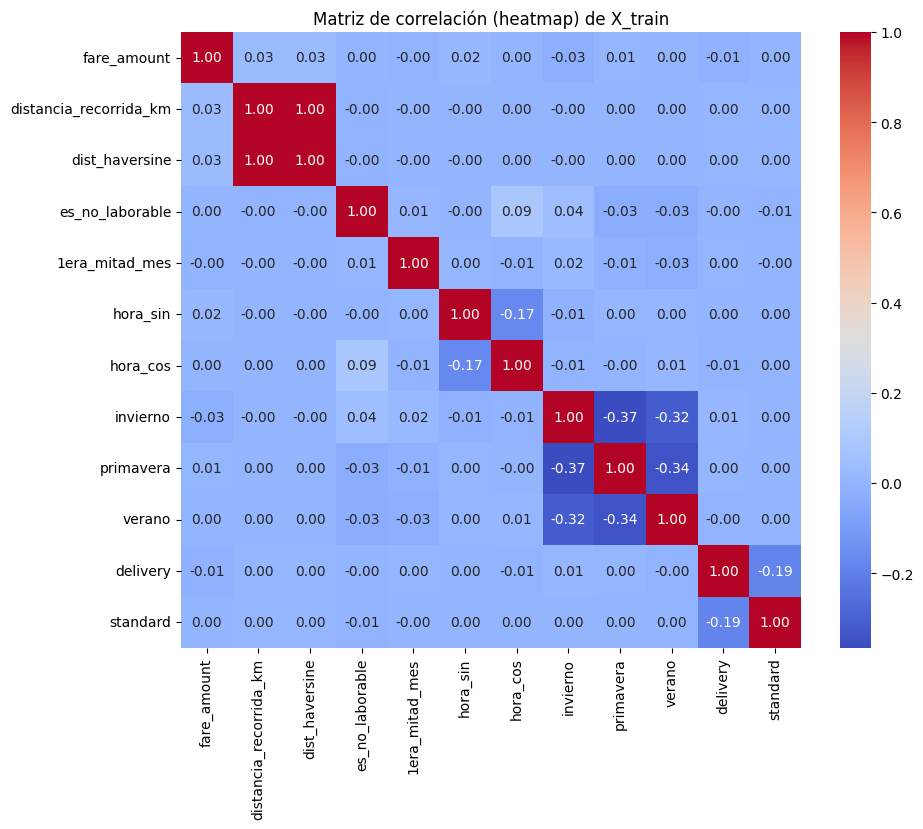

In [434]:
# Heatmap de la matriz de correlación de X_train
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap) de X_train')
plt.show()

In [432]:

# Escalar solo 'distancia_recorrida_km' y 'dist_haversine'
cols_to_scale = ['distancia_recorrida_km', 'dist_haversine']

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Escalar y (target)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Modelos con todas las variables además de la principal
X_km_train = X_train.drop(columns=["dist_haversine"])
X_km_test = X_test.drop(columns=["dist_haversine"])

X_hav_train = X_train.drop(columns=["distancia_recorrida_km"])
X_hav_test = X_test.drop(columns=["distancia_recorrida_km"])

# Modelo 1: Regresión lineal con distancia_recorrida_km
modelo_km = LinearRegression()
modelo_km.fit(X_km_train, y_train_scaled)
y_pred_km = modelo_km.predict(X_km_test)

# Modelo 2: Regresión lineal con dist_haversine
modelo_hav = LinearRegression()
modelo_hav.fit(X_hav_train, y_train_scaled)
y_pred_hav = modelo_hav.predict(X_hav_test)

# Evaluación simple de los modelos
print("Modelo con distancia_recorrida_km")
print("MSE:", mean_squared_error(y_test_scaled, y_pred_km))
print("RMSE:", np.sqrt(mean_squared_error(y_test_scaled, y_pred_km)))
print("MAE:", mean_absolute_error(y_test_scaled, y_pred_km))
print("MAPE:", np.mean(np.abs((y_test_scaled - y_pred_km) / y_test_scaled)) * 100)
print("R2:", r2_score(y_test_scaled, y_pred_km))

print("\nModelo con dist_haversine")
print("MSE:", mean_squared_error(y_test_scaled, y_pred_hav))
print("RMSE:", np.sqrt(mean_squared_error(y_test_scaled, y_pred_hav)))
print("MAE:", mean_absolute_error(y_test_scaled, y_pred_hav))
print("MAPE:", np.mean(np.abs((y_test_scaled - y_pred_hav) / y_test_scaled)) * 100)
print("R2:", r2_score(y_test_scaled, y_pred_hav))

Modelo con distancia_recorrida_km
MSE: 1.107951093690339
RMSE: 1.0525925582533533
MAE: 0.623143246866503
MAPE: 105.31335351970131
R2: 0.0010259616709088482

Modelo con dist_haversine
MSE: 1.1072589067541665
RMSE: 1.0522637058998883
MAE: 0.6229491905431669
MAPE: 105.29435304343974
R2: 0.001650065733664552


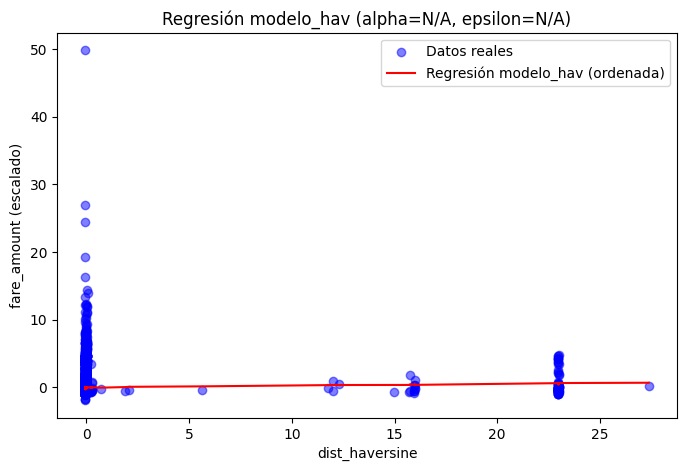

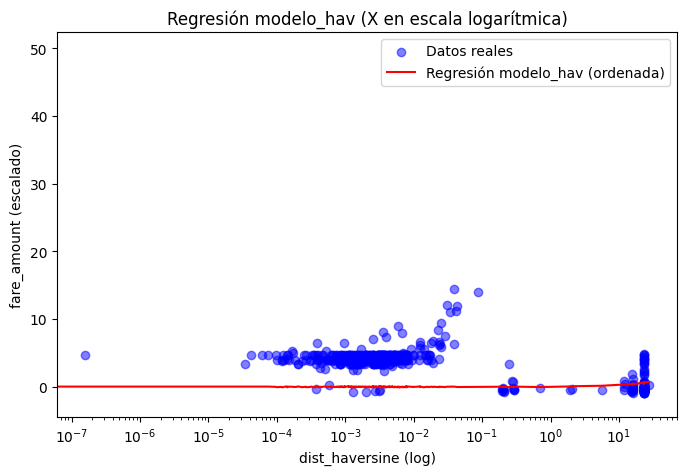

In [439]:
# Graficar la línea de regresión de modelo_hav ordenando X y usando escala logarítmica en X si hay mucha dispersión
import matplotlib.pyplot as plt
import numpy as np

# Predecir con el modelo modelo_hav
y_pred_hav = modelo_hav.predict(X_hav_test)

# Ordenar X_hav_test.iloc[:, 0] y y_pred_hav para la línea de regresión
x_vals = X_hav_test.iloc[:, 0].values
sort_idx = np.argsort(x_vals)
x_sorted = x_vals[sort_idx]
y_pred_sorted = y_pred_hav[sort_idx]

plt.figure(figsize=(8,5))
plt.scatter(X_hav_test.iloc[:, 0], y_test_scaled, color='blue', alpha=0.5, label='Datos reales')
plt.plot(x_sorted, y_pred_sorted, color='red', label='Regresión modelo_hav (ordenada)')
plt.xlabel(X_hav_test.columns[0])
plt.ylabel('fare_amount (escalado)')
alpha_val = getattr(modelo_hav, 'alpha', 'N/A')
epsilon_val = getattr(modelo_hav, 'epsilon', 'N/A')
plt.title(f'Regresión modelo_hav (alpha={alpha_val}, epsilon={epsilon_val})')
plt.legend()
plt.show()

# Visualización en escala logarítmica para X si hay mucha dispersión
plt.figure(figsize=(8,5))
plt.scatter(X_hav_test.iloc[:, 0], y_test_scaled, color='blue', alpha=0.5, label='Datos reales')
plt.plot(x_sorted, y_pred_sorted, color='red', label='Regresión modelo_hav (ordenada)')
plt.xlabel(X_hav_test.columns[0] + ' (log)')
plt.ylabel('fare_amount (escalado)')
plt.xscale('log')
plt.title(f'Regresión modelo_hav (X en escala logarítmica)')
plt.legend()
plt.show()

In [391]:
pd.DataFrame(y_train_scaled).describe()

,0
count,1.599680e+05
mean,-6.182958e-17
std,1.000003e+00
min,-9.043582e-01
25%,-5.468864e-01
50%,-2.915495e-01
75%,1.169896e-01
max,3.458748e+01


In [200]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [ ]:
# Evolución de los coeficientes de Ridge en función de alpha usando X_hav_train y y_train
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-4, 2, 100)
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_hav_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(15, 5))
for i, col in enumerate(X_hav_train.columns):
    ax.plot(alphas, coefs[:, i], label=col)
ax.set_xscale('log')
ax.set_xlabel('alpha (escala log)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los coeficientes de Ridge vs alpha')
plt.axis('tight')
plt.legend()
plt.show()
        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [202]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

NOS QUEDAMOS CON HAVERSINE PORQUE AJUSTA MEJOR

In [ ]:
# Ejemplo de reshape para cada conjunto de datos, útil si solo usás una variable predictora (columna)
y_train_rs = y_train.values.reshape(-1, 1)
y_test_rs = y_test.values.reshape(-1, 1)

X_hav_train
X_hav_test

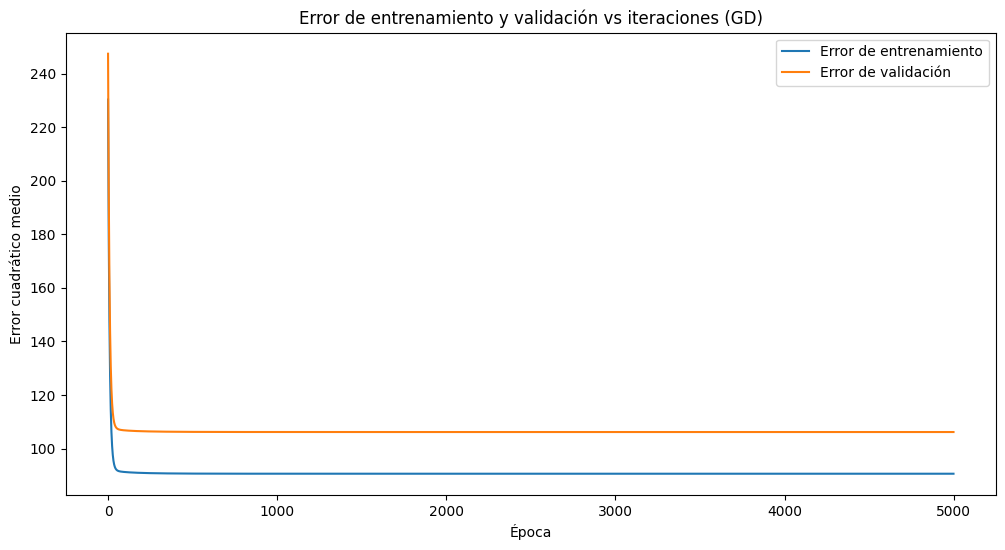

array([[4.55860757],
       [0.24848683],
       [0.03296115],
       [2.2372405 ],
       [2.2958578 ],
       [0.21593897],
       [0.01816075],
       [1.05657299],
       [1.61739716],
       [1.55707974],
       [1.88694716],
       [1.48884065],
       [3.0021088 ],
       [3.12533635]])

In [ ]:
gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.01, epochs=5000)

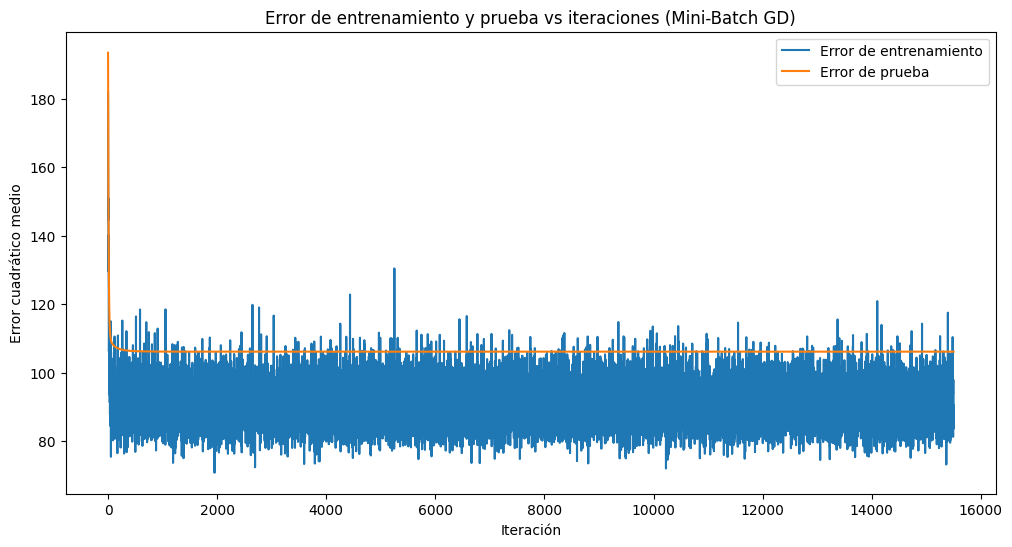

array([[6.1607851 ],
       [0.24612909],
       [0.01742977],
       [2.17757217],
       [2.23774933],
       [0.21815911],
       [0.02084091],
       [0.59095849],
       [2.98722682],
       [3.12756103]])

In [ ]:
mini_batch_gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.01, epochs=500, batch_size=5000)

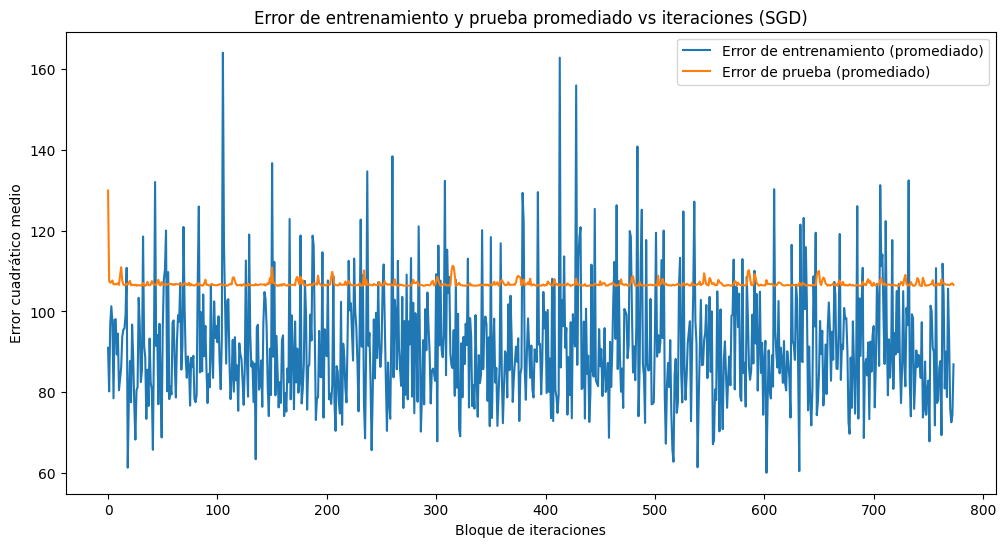

array([[6.03516285],
       [0.95690945],
       [0.11679807],
       [1.95693671],
       [1.51545845],
       [0.14004476],
       [0.24570199],
       [1.63656068],
       [3.68267656],
       [3.64730492]])

In [ ]:

def stochastic_gradient_descent_avg(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, avg_window=1000):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)
            W = W - (lr * gradient)

    # Promediar errores cada avg_window iteraciones
    def moving_average(arr, window):
        arr = np.array(arr).flatten()
        return [np.mean(arr[i:i+window]) for i in range(0, len(arr), window)]

    train_errors_avg = moving_average(train_errors, avg_window)
    test_errors_avg = moving_average(test_errors, avg_window)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors_avg, label='Error de entrenamiento (promediado)')
    plt.plot(test_errors_avg, label='Error de prueba (promediado)')
    plt.xlabel('Bloque de iteraciones')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba promediado vs iteraciones (SGD)')
    plt.show()

    return W

# Usar la función promediada:
stochastic_gradient_descent_avg(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.0005, epochs=5, avg_window=1000)

c:\Users\FZ\Desktop\TUIA_4TO\AA1\venvAA1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


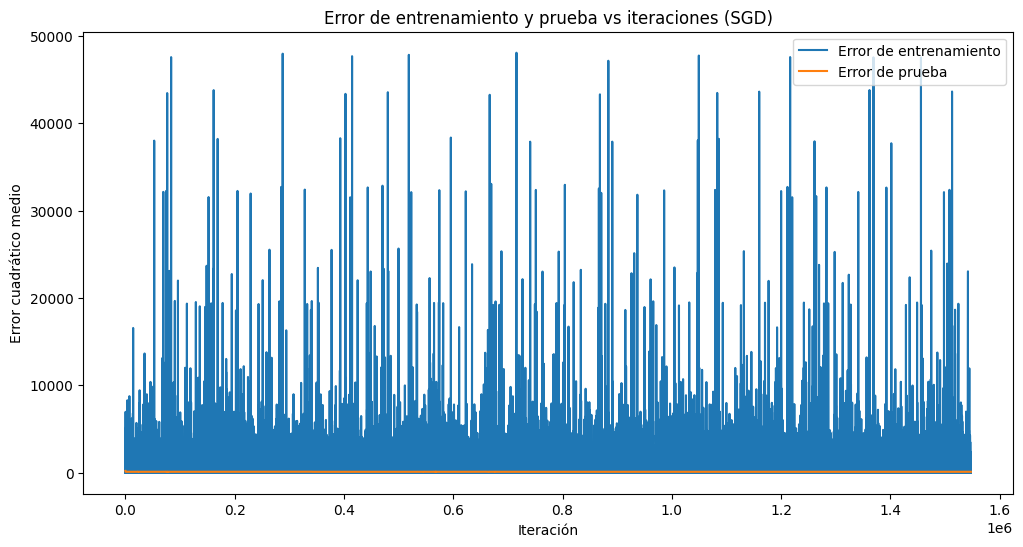

array([[ 5.52226616],
       [-0.31856647],
       [ 0.57684433],
       [ 4.13911715],
       [ 3.70948093],
       [ 0.63031402],
       [ 0.73973179],
       [ 0.0452189 ],
       [ 1.61954083],
       [ 2.09775714]])

In [ ]:
stochastic_gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.001, epochs=10)

# Ingeniería de Variables para Análisis de Viajes en Taxi

## 1. Creación de Variables Derivadas

### Distancia entre Origen y Destino
- **Distancia Euclidiana**: Calculada en grados entre dos puntos. Es rápida de calcular, aunque no representa la ruta real sobre la superficie terrestre.
- **Distancia Haversine**: Calculada en kilómetros o metros, es una medida más precisa para coordenadas geográficas, considerando la curvatura de la Tierra.
- **Distancia Absoluta (Manhattan)**: Suma de las diferencias absolutas de latitud y longitud, útil para aproximar trayectos en ciudades con calles en cuadrícula (como Manhattan).

### Características Temporales del Viaje
Extraídas a partir de `pickup_datetime`:
- **Hora del día** (`0-23`): Permite analizar si el horario influye en la tarifa.
- **Día de la semana** (`Lunes` a `Domingo`): Útil para detectar diferencias entre días laborables y fines de semana.
- **Semana del año**: Puede ayudar a detectar patrones estacionales o eventos especiales.
- **Mes** o **Estación del año**: Para analizar estacionalidad en la demanda.
- **¿Es hora pico?**: Variable booleana según franjas horarias (ej.: 7-9 AM y 5-7 PM).
- **¿Es fin de semana?**: Variable booleana para diferenciar sábados y domingos.

### Duración del Viaje
- Si se dispone del tiempo de llegada, calcular la duración real.
- Si no, **estimar la duración** utilizando la distancia y una velocidad promedio (ejemplo: duración = distancia / velocidad promedio).

### Variables de Interacción
- **Distancia × Cantidad de Pasajeros**: Para observar si viajes largos con más pasajeros modifican la tarifa por persona.
- **Hora × Día de la semana**: Permite captar efectos combinados entre horario y tipo de día.

---

## 2. Identificación y Tratamiento de Datos Problemáticos

### Valores Atípicos (Outliers)
- Detectar valores extremos en variables como distancia, tarifa o cantidad de pasajeros.
- Analizar si tienen sentido físico (ej.: viajes con distancia cero pero tarifa alta).

### Datos Faltantes (Missing Values)
- Identificar columnas con valores faltantes.
- Decidir el tratamiento adecuado: imputación, eliminación, o reemplazo según el caso.

---

### Notas
- Las variables temporales pueden codificarse como **cualitativas ordinales** para ciertos modelos (ej.: día de la semana, semana del año).
- La ingeniería de variables adecuada puede mejorar significativamente el rendimiento de los modelos de regresión y la interpretación de los resultados.

In [ ]:
# 4. Análisis y tratamiento de datos faltantes
# Comentario: Se identifican valores faltantes y se decide cómo tratarlos (eliminación, imputación, etc.).
# - df.isnull().sum()
# - Justificación de la decisión tomada

In [ ]:
# 5. Análisis y tratamiento de datos atípicos (outliers)
# Comentario: Se detectan y tratan valores atípicos en las variables numéricas.
# - Visualización con boxplots
# - Decisión sobre el tratamiento (eliminación, ajuste, etc.)

In [ ]:
# 6. Visualización de datos
# Comentario: Se grafican histogramas y scatterplots para analizar la distribución y relaciones entre variables.
# - Histograma de cada variable
# - Scatterplots entre variables relevantes
# - Diagramas de caja

In [ ]:
# 7. Codificación de variables categóricas (si corresponde)
# Comentario: Se codifican variables categóricas para su uso en modelos (OneHotEncoder, LabelEncoder, etc.).
# - Ejemplo: df['var'] = ...

In [ ]:
# 8. Matriz de correlación
# Comentario: Se calcula la matriz de correlación para analizar dependencias entre variables.
# - sns.heatmap(df.corr(), annot=True)

In [ ]:
# 9. Estandarización o escalado de datos
# Comentario: Se aplican técnicas de escalado para mejorar el desempeño de los modelos.
# - StandardScaler, MinMaxScaler, etc.

In [ ]:
# 11. Implementación de modelos de regresión
# 11.a. Regresión lineal múltiple (LinearRegression)
# Comentario: Se ajusta el modelo base de regresión lineal.

In [ ]:
# 11.b. Métodos de gradiente descendente (SGDRegressor, otros)
# Comentario: Se prueban diferentes variantes de gradiente descendente.
# - Se grafican errores vs iteraciones (loss vs epochs)

In [ ]:
# 12. Evaluación de modelos: métricas de regresión
# Comentario: Se calculan las métricas elegidas para train y test (R2, MSE, RMSE, MAE, MAPE).
# - Justificación de las métricas utilizadas

In [ ]:
# 13. Gráficos de residuos
# Comentario: Se grafican los residuos para analizar el ajuste de los modelos.


In [ ]:
# 14. Análisis de fitting y conclusiones intermedias
# Comentario: Se analiza el fitting del modelo y se discuten los efectos de la regularización y gradiente descendente.


In [ ]:
# 15. Optimización y comparación de hiperparámetros
# Comentario: Se varían los hiperparámetros y se observa el efecto en el desempeño del modelo.
# - GridSearchCV, RandomizedSearchCV, o análisis manual


In [ ]:
# 16. Comparación de modelos
# Comentario: Se compara el desempeño de los distintos modelos y se selecciona el mejor.
# - Justificación de la métrica de comparación